# Titanic Survival prediction – the very first Kaggle competition

## Introduction

The objective of this challenge is to build a **predictive ML model** that answers the question: "*what sorts of people were more likely to survive?*" (in the Titanic of course) using passenger data (i.e., name, age, gender, socio-economic class, etc). The training and test data\*\* sets are located in the folder *Data*. As this is a challenge, there is no target set.

This notebook shows my way through this challenge, starting by exploratory data analysis, feature engineering, preprocessing, hyperparameter tuning and comparison of the results. For this project, I used two linear ML algorithms (SGD and Logistic), four complex algorithms (Random Forest, Extra-Trees, Gradient Boosting [GB] and Extreme Gradient Boosting [XGB]) and a voting classifier. 

For this project we will base our results on **accuracy**, since it is the official metric used on the Kaggle leaderboard for this competition. However, for supporting our model, at the very end we also inspect the 
**ROC-AUC** score. 

\*\* This notebook is for **PRESENTATION PURPOSE**, that's why the data used in this project is self-contained.

In [1]:
# Data manipulation ---------------------------------------------------
import numpy as np
import pandas as pd 
# Visualization ---------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
try: 
    plt.rcParams.update({
    "text.usetex": True}) # I prefer LaTeX visualization.
except Exception:
    pass
# Preprocessing -------------------------------------------
from sklearn.pipeline import Pipeline # Setting the pipeline
from sklearn.impute import SimpleImputer # Fill in missing valued 
from sklearn.preprocessing import StandardScaler# Transformer to standard scale (most ML work better this way)
from sklearn.preprocessing import OneHotEncoder # Transformer for categorical attributes
from sklearn.compose import ColumnTransformer # Handles numerical and categorical columns separately
# Ensemble/algorithms -------------------------------------
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import VotingClassifier
# Score and metrics ----------------------------
from sklearn.model_selection import RandomizedSearchCV # For fine-tuning hyperparameters
from scipy.stats import randint # For random integers
from scipy.stats import reciprocal, uniform #for distributions of hyperparameters
from sklearn.model_selection import cross_val_score # To evaluate the models against the validation set
from sklearn.metrics import accuracy_score # The accuracy metric
from sklearn.metrics import classification_report # For model evaluation metrics
from sklearn.metrics import confusion_matrix # For confusion matrix in best-model evaluation
from sklearn.metrics import roc_auc_score # Roc_auc score

# Dataset overview

In [2]:
# First we fetch the training and test data sets
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [3]:
# See how does the train data set look like:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

-    `PassengerId`: a unique identifier for each passenger
-    `Survived`: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
-    `Pclass`: passenger class.
-    `Name`, `Sex`, `Age`: self-explanatory
-    `SibSp`: how many siblings & spouses of the passenger aboard the Titanic.
-    `Parch`: how many children & parents of the passenger aboard the Titanic.
-    `Ticket`: ticket id
-    `Fare`: price paid (in pounds)
-    `Cabin`: passenger's cabin number
-    `Embarked`: where the passenger embarked the Titanic

Let's check if there are missing attributes in the sets:

In [4]:
test_missing = [col for col in train_data.columns if col not in test_data.columns]
train_missing = [col for col in test_data.columns if col not in train_data.columns]
test_missing, train_missing

(['Survived'], [])

The only difference between train and test data is the `Survived` attribute in test. This makes sense since there is no target data set.

Now, let's check the general information of the train data set:

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Many NaN in attributes `Age` and `Cabin`, and two in attribute `Embarked`. We will deal with the missing entries later. Now, let's look at the general statistical information for the numerical attributes:

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Some observations:

- 75% of ticket fares were <= 31 pounds. While the maximum fare is extremely high. Such large value inflates the standard deviation (std) and suggests that less than 25% of passengers traveled  first class.
- Only about 38% of passengers survived, and the average age was less than 30 years old.
- There are only three passenger classes: first, second, and third.

Since we want to *predict* passenger survival based on the given data, we use **accuracy** as our primary performance metric (it is also the official Kaggle competition metric) and **ROC-AUC** as a complementary measure of quality in the model.

First, let's make `PassengerID` the index column.

In [7]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

# Exploratory Data Analysis

In [8]:
train_data["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot: >

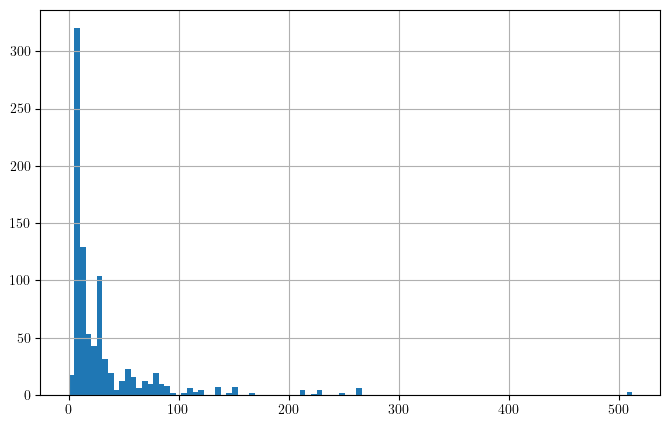

In [9]:
train_data["Fare"].hist(bins=100, figsize=(8,5))

The majority of the sold tickets were relatively cheap (?). So... most of the people belong to the third class? Let's find out.

In [10]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

YES! 491 out of 891 people (more than half) belong to the third class. This might be relevant.

How many people died/survived?

In [11]:
train_data["Survived"].value_counts() # 0 means died, 1 means survived

Survived
0    549
1    342
Name: count, dtype: int64

549 died and 342 survived. So, around 62% died and 38% survived. Roughly speaking 2 of 3 people died. 

Let's see the gender of these people:

In [12]:
total_sex = train_data["Sex"].value_counts()
total_sex

Sex
male      577
female    314
Name: count, dtype: int64

There were 577 men and 314 women (only in the train data set of course). 

Let's see their age in general, depending on the class:

In [13]:
train_data.groupby(['Pclass', 'Sex'])['Age'].agg(['median', 'mean']).round(1)

median  mean
Pclass Sex                 
1      female    35.0  34.6
       male      40.0  41.3
2      female    28.0  28.7
       male      30.0  30.7
3      female    21.5  21.8
       male      25.0  26.5

In first class we have the oldest mean ages. In all classes, men are older than women.

Let's see how many people died,according to sex:

In [14]:
total_male_female = total_sex.values
for k, sex in enumerate(total_sex.index):
    tem_data = train_data[train_data["Sex"]==sex]
    count_i = tem_data[tem_data["Survived"] == 1]["Survived"].count()
    print(f"{count_i} {sex}s survived and {total_male_female[k]-count_i} did not survive.")

109 males survived and 468 did not survive.
233 females survived and 81 did not survive.


**This is probably crucial!** From all dead people, 85% were men (15% women). While from all men, 81% died, and from all women, only 26% died. 

Natural conclusion: mostly women survived (or mostly men did not)!!! If you were a lady, your chances to survive are higher. Of course, **it's natural, women and kids first**.

**Let's summary all this information** featuring the class of the passengers:

In [15]:
pd.crosstab(
    [train_data["Sex"], train_data["Pclass"]],
    train_data["Survived"],
    normalize="index" #normalized by row, i.e., by sex and Pclass
)

Survived              0         1
Sex    Pclass                    
female 1       0.031915  0.968085
       2       0.078947  0.921053
       3       0.500000  0.500000
male   1       0.631148  0.368852
       2       0.842593  0.157407
       3       0.864553  0.135447

Mostly high-class (first and second) women survived!!! If you were a third-class woman, your chances are 50-50!!! This is amazing. 

While for men, only first class men had *a chance* to survive. Roughly 7 of 20.

Let's see the same information but normalized by the column `Survived`:

In [16]:
pd.crosstab(
    [train_data["Sex"], train_data["Pclass"]],
    train_data["Survived"],
    normalize="columns" #normalized by columns: did not survive, survived.
)

Survived              0         1
Sex    Pclass                    
female 1       0.005464  0.266082
       2       0.010929  0.204678
       3       0.131148  0.210526
male   1       0.140255  0.131579
       2       0.165756  0.049708
       3       0.546448  0.137427

This table shows us that, that women had a chance to survive of at least 20% independently of their class (of course, first class has a higher expectation. This is roughly speaking). However, notice that more than 56% of people, who did not survive, were men in third class!

In [17]:
# Let's do the same but with EMBARKED attribute, and see is there a relation:
pd.crosstab(
    [train_data["Embarked"], train_data["Pclass"]],
    train_data["Survived"],
    normalize="index"
)

Survived                0         1
Embarked Pclass                    
C        1       0.305882  0.694118
         2       0.470588  0.529412
         3       0.621212  0.378788
Q        1       0.500000  0.500000
         2       0.333333  0.666667
         3       0.625000  0.375000
S        1       0.417323  0.582677
         2       0.536585  0.463415
         3       0.810198  0.189802

Let's do the same but with EMBARKED attribute, and see is there a relation:

In [18]:
pd.crosstab(
    [train_data["Embarked"], train_data["Pclass"]],
    train_data["Survived"],
    normalize="columns"
)

Survived                0         1
Embarked Pclass                    
C        1       0.047359  0.173529
         2       0.014572  0.026471
         3       0.074681  0.073529
Q        1       0.001821  0.002941
         2       0.001821  0.005882
         3       0.081967  0.079412
S        1       0.096539  0.217647
         2       0.160291  0.223529
         3       0.520947  0.197059

Notice that `Embarked = S` and `Pclass =3` has the highest number of "people who did not survive", just as in `Sex = male` and the same class. However, the highest percentage of survival people lie also in `Embarked = S`. We can conclude that many women of all classes embarked in `S` and mainly men of third class embarked in `S`. This can be checked in the next table: 

In [19]:
# Let's do the same but with EMBARKED attribute, and see is there a relation:
pd.crosstab(
    [train_data["Embarked"], train_data["Sex"], train_data["Pclass"]],
    train_data["Survived"],
    normalize="columns"
)

Survived                       0         1
Embarked Sex    Pclass                    
C        female 1       0.001821  0.123529
                2       0.000000  0.020588
                3       0.014572  0.044118
         male   1       0.045537  0.050000
                2       0.014572  0.005882
                3       0.060109  0.029412
Q        female 1       0.000000  0.002941
                2       0.000000  0.005882
                3       0.016393  0.070588
         male   1       0.001821  0.000000
                2       0.001821  0.000000
                3       0.065574  0.008824
S        female 1       0.003643  0.135294
                2       0.010929  0.179412
                3       0.100182  0.097059
         male   1       0.092896  0.082353
                2       0.149362  0.044118
                3       0.420765  0.100000

In [20]:
#Age/sex distribution survival prob.
train_data["Age_15"] = train_data["Age"] // 15 * 15
pd.crosstab(
    [train_data["Age_15"], train_data["Sex"]],
    train_data["Survived"],
    normalize="columns"
)

Survived              0         1
Age_15 Sex                       
0.0    female  0.035377  0.082759
       male    0.042453  0.072414
15.0   female  0.063679  0.279310
       male    0.396226  0.103448
30.0   female  0.035377  0.217241
       male    0.257075  0.096552
45.0   female  0.016509  0.086207
       male    0.108491  0.037931
60.0   female  0.000000  0.013793
       male    0.044811  0.006897
75.0   male    0.000000  0.003448

We notice that older women from around 60 survived, while young and old men did not. Checking the survival prob of the eldery:

In [21]:
train_data[["Age_15", "Survived"]].groupby(['Age_15']).mean()

,Survived
Age_15,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [22]:
train_data.drop("Age_15", axis = 1, inplace = True)

# Feature engineering

A lot of data is correlated here. We know that the main attributes are `Sex` and `Pclass`. The name tells us the sex, and according to the title, it can indirectly point out the class the passenger was on. `Cabin` may indicate where the passenger was on the ship, which is related to `Pclass` and potentially to proximity to lifeboats. Rather than dropping it entirely, we extract the **deck letter** (the first character of the cabin number: A, B, C, D, E, F, G) as a new feature `Deck`. Since ~77% of passengers have no cabin recorded, missing values are filled with `"U"` (for Unknown), which becomes its own category. This way the model can still learn from the passengers whose cabin is known, without discarding the information completely.

In [23]:
train_data["Deck"] = train_data["Cabin"].str[0]  # extracts first letter
train_data["Deck"] = train_data["Deck"].fillna("U")
test_data["Deck"] = test_data["Cabin"].str[0]  
test_data["Deck"] = test_data["Deck"].fillna("U")
train_data.drop("Cabin", axis = 1, inplace = True)
test_data.drop("Cabin", axis = 1, inplace = True)

`SibSp` tells us how many siblings & spouses of the passenger aboard the Titanic, and  `Parch` how many children & parents of the passenger aboard the Titanic. It is better if we join these two attributes into a single one, `FamilySize`, 

In [24]:
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1 # +1 stands for oneself.
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"] + 1

In [25]:
train_data[["FamilySize", "Survived"]].groupby(['FamilySize']).mean()

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


In general, people with 1, 2 or 3 relatives have the highest survival probability.

In [26]:
train_data.drop(
    columns=["SibSp", "Parch"],
    errors="ignore",
    inplace=True)
test_data.drop(
    columns=["SibSp", "Parch"],
    errors="ignore", inplace = True)

Since `Sex` and `Pclass` appear to be very important attributes, let's see their distribution:

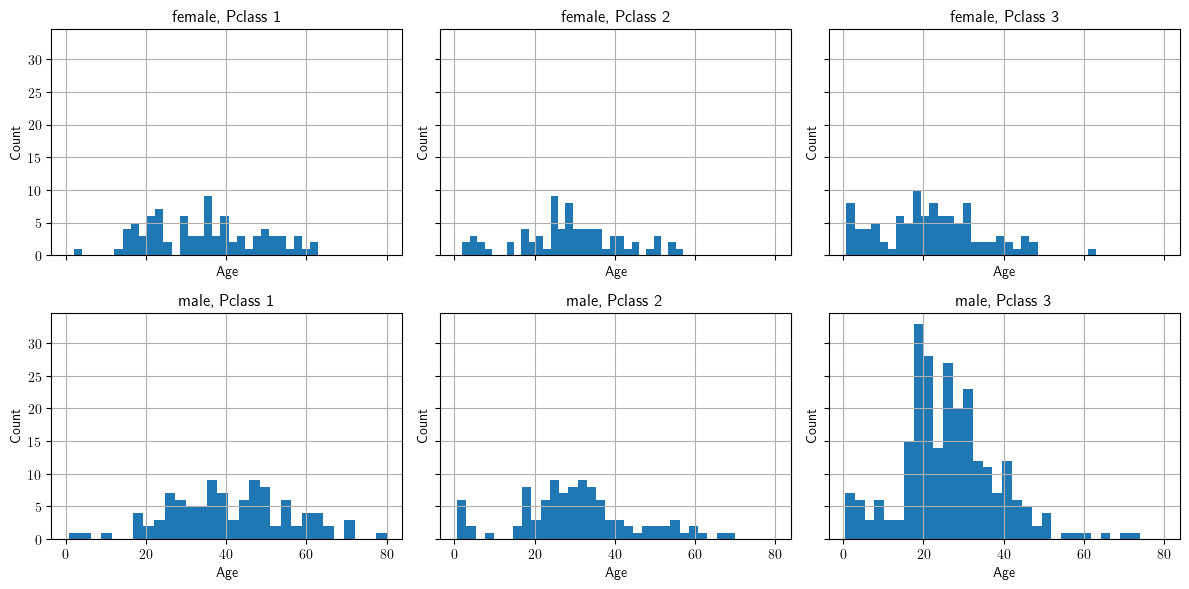

In [27]:
sexes = ["female", "male"]
pclasses = [1, 2, 3]

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 6),
    sharex=True,
    sharey=True
)

for i, sex in enumerate(sexes):
    for j, pclass in enumerate(pclasses):
        
        ax = axes[i, j]
        
        subset = train_data[
            (train_data["Sex"] == sex) &
            (train_data["Pclass"] == pclass)
        ]
        
        subset["Age"].hist(
            bins=30,
            ax=ax
        )
        
        ax.set_title(f"{sex}, Pclass {pclass}")
        ax.set_xlabel("Age")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

Third class male distribution is definitely different to the others. So, it is important to fill the NaN in `Age` accordingly.

In [28]:
train_data["Age"] = train_data.groupby(
    ["Sex", "Pclass"]
)["Age"].transform(lambda x: x.fillna(x.median()))
test_data["Age"] = test_data.groupby(
    ["Sex", "Pclass"]
)["Age"].transform(lambda x: x.fillna(x.median()))

**Observation**: By filling in the training data at this point, the pipeline will be simpler and no redundant operations are going to be performed. However, this is a particular case. For generalization (use other data) or for constant training it is better to use `SimpleImputer` in the pipeline. Otherwise there is a risk of data leakage if not careful.

The name of the passenger is sort of irrelevant. We already know the sex of the passenger. Although, the title on the name can indirectly give us information about his social status, which may contribute with Pclass.

In [29]:
train_data["Title"] = train_data["Name"].str.extract(r"([A-Za-z]+)\.", expand=False)
train_data["Title"] = train_data["Title"].replace(
    ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"], "Rare")
train_data["Title"] = train_data["Title"].replace(["Mlle","Ms","Mme"], "Miss")

In [30]:
train_data["Title"]

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887    Rare
888    Miss
889    Miss
890      Mr
891      Mr
Name: Title, Length: 891, dtype: object

In [31]:
pd.crosstab(
    [train_data["Pclass"], train_data["Title"]],
    train_data["Survived"],
    normalize="columns"
)

Survived              0         1
Pclass Title                     
1      Master  0.000000  0.008772
       Miss    0.003643  0.137427
       Mr      0.127505  0.108187
       Mrs     0.001821  0.119883
       Rare    0.012750  0.023392
2      Master  0.000000  0.026316
       Miss    0.003643  0.096491
       Mr      0.151184  0.023392
       Mrs     0.007286  0.108187
       Rare    0.014572  0.000000
3      Master  0.030965  0.032164
       Miss    0.092896  0.149123
       Mr      0.515483  0.105263
       Mrs     0.038251  0.061404

In general, Miss has the highest survival prob.,  while Mr has the highest for "did not survive".

Now, the attribute `Name` can relate to the family, which as we know, increases the survival probability. This however, is already considered by `FamilySize`. Furthermore, many new last names can appear in the test set. So, we drop Name.

In [32]:
train_data.drop("Name", axis = 1, inplace = True)

test_data["Title"] = test_data["Name"].str.extract(r"([A-Za-z]+)\.", expand=False)
test_data["Title"] = test_data["Title"].replace(
    ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"], "Rare")
test_data["Title"] = test_data["Title"].replace(["Mlle","Ms","Mme"], "Miss")
test_data.drop("Name", axis = 1, inplace = True)

In [33]:
train_data.head(10)

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Deck,FamilySize,Title
PassengerId,,,,,,,,,,
1,0,3,male,22.0,A/5 21171,7.2500,S,U,2,Mr
2,1,1,female,38.0,PC 17599,71.2833,C,C,2,Mrs
3,1,3,female,26.0,STON/O2. 3101282,7.9250,S,U,1,Miss
4,1,1,female,35.0,113803,53.1000,S,C,2,Mrs
5,0,3,male,35.0,373450,8.0500,S,U,1,Mr
6,0,3,male,25.0,330877,8.4583,Q,U,1,Mr
7,0,1,male,54.0,17463,51.8625,S,E,1,Mr
8,0,3,male,2.0,349909,21.0750,S,U,5,Master
9,1,3,female,27.0,347742,11.1333,S,U,3,Mrs


The data looks better, but there is still missing data in `Embarked` (2 features actually).

In [34]:
train_data[train_data["Embarked"].isna() == True]

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Deck,FamilySize,Title
PassengerId,,,,,,,,,,
62,1,1,female,38.0,113572,80.0,NaN,B,1,Miss
830,1,1,female,62.0,113572,80.0,NaN,B,1,Mrs


Notice that they were traveling alone or with friends, but without family. Since we don't have much data we keep these entries. They will be filled in the pipeline later.

In [35]:
# Finally, let's deal with tickets"
pd.crosstab(
    [train_data["Pclass"], train_data["Sex"]],
    train_data["Ticket"]
)

Ticket         110152  110413  110465  110564  110813  111240  111320  111361  \
Pclass Sex                                                                      
1      female       3       2       0       0       1       0       0       2   
       male         0       1       2       1       0       1       1       0   
2      female       0       0       0       0       0       0       0       0   
       male         0       0       0       0       0       0       0       0   
3      female       0       0       0       0       0       0       0       0   
       male         0       0       0       0       0       0       0       0   

Ticket         111369  111426  ...  STON/O2. 3101290  SW/PP 751  W./C. 14258  \
Pclass Sex                     ...                                             
1      female       0       0  ...                 0          0            0   
       male         1       1  ...                 0          0            0   
2      female       0       0  ...                 0          0            1   
       male         0       0  ...                 0          1            0   
3      female       0       0  ...                 1          0            0   
       male         0       0  ...                 0          0            0   

Ticket         W./C. 14263  W./C. 6607  W./C. 6608  W./C. 6609  W.E.P. 5734  \
Pclass Sex                                                                    
1      female            0           0           0           0            0   
       male              0           0           0           0            1   
2      female            0           0           0           0            0   
       male              1           0           0           0            0   
3      female            0           1           3           1            0   
       male              0           1           1           0            0   

Ticket         W/C 14208  WE/P 5735  
Pclass Sex                           
1      female          0          1  
       male            0          1  
2      female          0          0  
       male            1          0  
3      female          0          0  
       male            0          0  

[6 rows x 681 columns]

Although there are hundreds of unique values for `Ticket`, some of them repeat! At the beginning of the above table we see that three women booked a single ticket (110152). In other words, they traveled together! Let's see the survival for those women:

In [36]:
train_data[train_data["Ticket"] == "110152"]

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Deck,FamilySize,Title
PassengerId,,,,,,,,,,
258,1,1,female,30.0,110152,86.5,S,B,1,Miss
505,1,1,female,16.0,110152,86.5,S,B,1,Miss
760,1,1,female,33.0,110152,86.5,S,B,1,Rare


They all survived!!! Although, they were probably only friends, since they traveled without a family. So, people that traveled together with somebody, even without their own family, have a better chance to survive. Therefore, `Ticket` contributes to the prediction. However, what is important is not the ticket id *per se*, but how many people share the same ticket.

In [37]:
train_data["TicketGroupSize"] = train_data.groupby("Ticket")["Ticket"].transform("count")
test_data["TicketGroupSize"] = test_data.groupby("Ticket")["Ticket"].transform("count")
train_data.drop("Ticket", axis = 1, inplace = True)
test_data.drop("Ticket", axis = 1, inplace = True)

In [38]:
# One more check for NaN.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Sex              891 non-null    object 
 3   Age              891 non-null    float64
 4   Fare             891 non-null    float64
 5   Embarked         889 non-null    object 
 6   Deck             891 non-null    object 
 7   FamilySize       891 non-null    int64  
 8   Title            891 non-null    object 
 9   TicketGroupSize  891 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


All good!! Now let's check the test data set

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           418 non-null    int64  
 1   Sex              418 non-null    object 
 2   Age              418 non-null    float64
 3   Fare             417 non-null    float64
 4   Embarked         418 non-null    object 
 5   Deck             418 non-null    object 
 6   FamilySize       418 non-null    int64  
 7   Title            418 non-null    object 
 8   TicketGroupSize  418 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 32.7+ KB


One missing Fare value was found in the test set.
Since Fare is an important predictive feature, the value must be fill in
using the median fare by class from the training dataset to avoid data leakage.

In [40]:
test_data[test_data["Fare"].isna() == True]

,Pclass,Sex,Age,Fare,Embarked,Deck,FamilySize,Title,TicketGroupSize
PassengerId,,,,,,,,,
1044,3,male,60.5,NaN,S,U,1,Mr,1


In [41]:
fare_by_class = train_data.groupby("Pclass")["Fare"].median()
test_data["Fare"] = test_data["Fare"].fillna(
    test_data["Pclass"].map(fare_by_class)
)

In [42]:
test_data[test_data.index == 1044] # Done

,Pclass,Sex,Age,Fare,Embarked,Deck,FamilySize,Title,TicketGroupSize
PassengerId,,,,,,,,,
1044,3,male,60.5,8.05,S,U,1,Mr,1


### Preprocessing -- Transformation Pipelines

Since we want to test different algorithms, we first transform the data only once, and then apply it directly on all the models.

In [43]:
# Now the fun may start:
num_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder()),
    ])


In [44]:
num_attribs = ["Pclass", "Age", "Fare", "FamilySize", "TicketGroupSize"]
cat_attribs = ["Sex", "Embarked", "Title", "Deck"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

We shall use the `Survived` attribute for the target training set and drop it from the training data set:

In [45]:
y_train = train_data["Survived"]
train_data_no_Survived = train_data.drop(columns="Survived", axis =1) 
# Applying the transformers, we get the training data set for traning and test set for the result.
X_train = preprocess_pipeline.fit_transform(train_data_no_Survived[num_attribs + cat_attribs])
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])

# Modeling

For the survival classification we will use different (binary) classification models. In order to obtain good results a `RandomizedSearchCV` is going to be used on some algorithm hyperparameters twice. Notice that for this project we will not be using ANN or similar. That would be covered in a different notebook.

Before starting, we would like to define two functions that are going to be called at least five times in this work:

In [46]:
def best_params_score(X): 
    #shows the best parameters found by RandomizedSearchCV and the score in the training data set.
    print("Best params:", X.best_params_)
    print("Best CV score:", X.best_score_)
    
def my_randomizedSearchCV(model, model_param_distributions, n_iter=200,cv=5):
    #Finds the best parameters of model from a random selection of model_param_distributions.
    output_model = RandomizedSearchCV(
                    model, # the model
                    param_distributions=model_param_distributions, #distribution of model parameters
                    n_iter=n_iter, # Number of random combinations to try
                    cv=cv, # Cross-validation folds
                    scoring='accuracy', # Metric to optimize 
                    random_state=42, # For reproducible results
                    verbose = 1, 
                    n_jobs = -1, # all processors working
                    )
    output_model.fit(X_train, y_train);
    best_params_score(output_model)
    # returns the best model found
    return output_model

## Linear Models
### SGD Classifier

In [47]:
sgd_clf = SGDClassifier(
    loss='log_loss',        # logistic regression
    tol=1e-3, #The stopping criterion. Set to the default value
    early_stopping = True, # early stop
    random_state=42
)
# Dictionary of parameters to try with their distributions:
sgd_clf_param_dist = {
    "alpha": reciprocal(0.001, 0.2), # Constant that multiplies the regularization term
    "max_iter": randint(200, 2000), # The maximum number of passes over the training data (aka epochs)  
    "penalty": ['l2', 'l1', 'elasticnet'], # Regularization l2, 
    "learning_rate": ['optimal', 'adaptive'],  # Usually best choices
    "eta0": reciprocal(0.001, 1),  # For adaptive learning rate
}

In [48]:
sgd_clf_model = my_randomizedSearchCV(sgd_clf,sgd_clf_param_dist)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'alpha': 0.0032696459743243116, 'eta0': 0.7756532531954861, 'learning_rate': 'adaptive', 'max_iter': 884, 'penalty': 'l2'}
Best CV score: 0.8293955181721172


**Second stage**: After the broad *random* search, let's narrow the parameter ranges around the best values found.

In [49]:
best = sgd_clf_model.best_params_
sgd_clf_param_dist.update({
    "penalty": [best['penalty']],
    "learning_rate": [best['learning_rate']],
    "eta0": uniform(best['eta0'] * 0.5, best['eta0'] * 1.5),
    "alpha": uniform(best['alpha'] * 0.5, best['alpha'] * 1.5),
    "max_iter": randint(max(100,best['max_iter'] - 200), best['max_iter'] + 200),
})
sgd_clf_model = my_randomizedSearchCV(sgd_clf,sgd_clf_param_dist)
sgd = sgd_clf_model.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'alpha': 0.0033075723196955963, 'eta0': 0.519850785450458, 'learning_rate': 'adaptive', 'max_iter': 834, 'penalty': 'l2'}
Best CV score: 0.8316427091833531


Almost 83%, this is not bad. 

### Logistic Regression

In [50]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf_param_dist = {
    "C": reciprocal(1, 200),
    "max_iter": randint(200, 2000), 
    "penalty": ["l2", "l1"]
}
log_clf_model = my_randomizedSearchCV(log_clf, log_clf_param_dist)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'C': 1.19985569888572, 'max_iter': 405, 'penalty': 'l2'}
Best CV score: 0.8316552633230808


The `elasticnet` penalty was also considered using `solver="saga"`, but it requires `l1_ratio` as an additional hyperparameter that cannot be searched conditionally within `RandomizedSearchCV`, leading to fit failures. For this reason, it was discarded and `solver="liblinear"` was kept with `l1` and `l2` penalties only.

In [51]:
# Second stage
best = log_clf_model.best_params_
log_clf_param_dist.update({
    "penalty": [best['penalty']],
    "C": uniform(best['C'] * 0.5, best['C'] * 1.5),
    "max_iter": randint(max(100,best['max_iter'] - 200), best['max_iter'] + 200),
})
log_clf_model = my_randomizedSearchCV(log_clf,log_clf_param_dist)
log = log_clf_model.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'C': 0.6013294593915179, 'max_iter': 481, 'penalty': 'l2'}
Best CV score: 0.8338961772644531


Also 83%. Both linear models predict with the same accuracy.

Let's use more complex models: `RandomForestClassifier`, `ExtraTreesClassifier` and `GradientBoostingClassifier`.

## Complex models

### Random Forest

In [52]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf_param_dist = {
    "n_estimators": randint(200, 2000),  # Number of trees in the forest. ---
    "max_depth": randint(2, 10),  # Maximum depth of each tree; deeper trees can overfit. ---
    "max_leaf_nodes": randint(2, 10),  # Maximum number of leaf nodes; 2 is the minimum valid value. ---
    'bootstrap': [True, False]  # Whether to build trees on bootstrap samples of the training data. ---
}
rnd_clf_model = my_randomizedSearchCV(rnd_clf, rnd_clf_param_dist)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'bootstrap': False, 'max_depth': 9, 'max_leaf_nodes': 9, 'n_estimators': 1615}
Best CV score: 0.8260247316552632


In [53]:
# Second stage
best = rnd_clf_model.best_params_
rnd_clf_param_dist.update({
    "bootstrap": [best['bootstrap']],
    "max_depth": randint(max(2,best['max_depth'] - 1), best['max_depth'] + 1),
    "max_leaf_nodes": randint(max(2,best['max_leaf_nodes'] - 1), best['max_leaf_nodes'] + 1),
    "n_estimators": randint(max(100,best['n_estimators'] - 200), best['n_estimators'] + 200),
})
rnd_clf_model = my_randomizedSearchCV(rnd_clf,rnd_clf_param_dist)
rnd = rnd_clf_model.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'bootstrap': False, 'max_depth': 8, 'max_leaf_nodes': 9, 'n_estimators': 1763}
Best CV score: 0.8260247316552632


Still 83%. This model is not better than the previous two models.

### Extra-Trees 
Models are based on a forest of extremely random trees and training it is *faster* than regular Random Forests. 

In [54]:
ext_clf = ExtraTreesClassifier(random_state=42)
ext_clf_param_dist = {
     "n_estimators": randint(100, 2000),
     "max_depth": randint(2, 10),
     "max_leaf_nodes": randint(2, 10),
     'bootstrap': [True, False]
}
ext_clf_model = my_randomizedSearchCV(ext_clf,ext_clf_param_dist)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'bootstrap': False, 'max_depth': 9, 'max_leaf_nodes': 9, 'n_estimators': 230}
Best CV score: 0.8170296905404557


In [55]:
# Second stage
best = ext_clf_model.best_params_
ext_clf_param_dist.update({
    "bootstrap": [best['bootstrap']],
    "max_depth": randint(max(2,best['max_depth'] - 1), best['max_depth'] + 1),
    "max_leaf_nodes": randint(max(2,best['max_leaf_nodes'] - 1), best['max_leaf_nodes'] + 1),
    "n_estimators": randint(max(100,best['n_estimators'] - 200), best['n_estimators'] + 200),
})
ext_clf_model = my_randomizedSearchCV(ext_clf,ext_clf_param_dist)
ext = ext_clf_model.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'bootstrap': False, 'max_depth': 8, 'max_leaf_nodes': 9, 'n_estimators': 236}
Best CV score: 0.81814700897621


This model is not better than the others (82% against 83%).

### Gradient Boosting

In [56]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf_param_dist = {
    "n_estimators": randint(100, 2001),  # Number of sequential trees (boosting stages). ---
    "max_depth": randint(2, 8),  # Keep trees shallow for boosting; deeper trees tend to overfit. ---
    "learning_rate": reciprocal(0.001, 0.1),  # Shrinks each tree's contribution; lower = slower but often better. ---
    "subsample": uniform(0.5, 0.3)  # Fraction of training samples used per tree (0.5 to 0.8); adds stochasticity. ---
}
gb_clf_model = my_randomizedSearchCV(gb_clf, gb_clf_param_dist)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'learning_rate': 0.04045403638787862, 'max_depth': 2, 'n_estimators': 775, 'subsample': 0.5532318631339168}
Best CV score: 0.8451195781809051


In [57]:
# Second stage
best = gb_clf_model.best_params_
gb_clf_param_dist.update({
    "n_estimators": randint(max(100, best['n_estimators'] - 200),best['n_estimators'] + 200),
    "max_depth": randint(max(2,best['max_depth'] - 1), best['max_depth'] + 1),
    "learning_rate": uniform(best['learning_rate'] * 0.5,best['learning_rate']),  # Uniform from 0.5*lr to 1.5*lr
    "subsample": uniform(max(0.5, best['subsample'] - 0.1), 0.2),
})
gb_clf_model = my_randomizedSearchCV(gb_clf,gb_clf_param_dist)
gb = gb_clf_model.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'learning_rate': 0.040155692088504225, 'max_depth': 2, 'n_estimators': 715, 'subsample': 0.5810404173562834}
Best CV score: 0.8473604921222775


This is a bit better, 85%!

### Extreme Gradient Boosting

This algorithm is like the previous one but including regularization terms and runs much faster.

In [58]:
xgb_clf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'  # suppresses a default metric warning
)

xgb_clf_param_dist = {
    "n_estimators":      randint(100, 2000),
    "max_depth":         randint(2, 8),
    "learning_rate":     reciprocal(0.01, 0.3),
    "subsample":         uniform(0.5, 0.5),    # Subsample ratio of the training instance; 0.5 → 1.0
    "colsample_bytree":  uniform(0.5, 0.5),    # fraction of features per tree
    "reg_alpha":         uniform(0, 10),         # L1 regularisation
    "reg_lambda":        uniform(0, 10),         # L2 regularisation (1.0 → 5.0)
    "min_child_weight":  randint(1, 10),        # minimum samples needed to create a leaf
}

xgb_clf_model = my_randomizedSearchCV(xgb_clf, xgb_clf_param_dist)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'colsample_bytree': 0.9822602361351043, 'learning_rate': 0.13266339856683923, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1630, 'reg_alpha': 4.09334006315043, 'reg_lambda': 8.940992036791345, 'subsample': 0.6149773029455431}
Best CV score: 0.8541020651559851


In [59]:
best_xgb = xgb_clf_model.best_params_
# This is for the new dictionary, since we are dealing with parameters in [0,1]:
# ----------------------------------------------------
cb_i = max(0.0, best_xgb['colsample_bytree'] - 0.1)
cb_f = min(1.0, best_xgb['colsample_bytree'] + 0.1)
ss_i = max(0.0, best_xgb['subsample'] - 0.1)
ss_f = min(1.0, best_xgb['subsample'] + 0.1)
# ----------------------------------------------------
xgb_clf_param_dist.update({
    "n_estimators":     randint(max(100, best_xgb['n_estimators'] - 200), best_xgb['n_estimators'] + 200),
    "max_depth":        randint(max(2, best_xgb['max_depth'] - 1), best_xgb['max_depth'] + 2),
    "learning_rate":    uniform(best_xgb['learning_rate'] * 0.5, best_xgb['learning_rate']),
    "subsample": uniform(ss_i, ss_f - ss_i),
    "colsample_bytree": uniform(cb_i, cb_f - cb_i),
    "reg_alpha":        uniform(max(0, best_xgb['reg_alpha'] - 0.2), 0.4),
    "reg_lambda":       uniform(max(1, best_xgb['reg_lambda'] - 0.5), 1.0),
    "min_child_weight": randint(max(1, best_xgb['min_child_weight'] - 2), best_xgb['min_child_weight'] + 3),
})
xgb_clf_model = my_randomizedSearchCV(xgb_clf, xgb_clf_param_dist)
xgb = xgb_clf_model.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params: {'colsample_bytree': 0.9413885580656336, 'learning_rate': 0.14531749913687306, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 1808, 'reg_alpha': 4.213252871980138, 'reg_lambda': 8.790379035840678, 'subsample': 0.608623668633819}
Best CV score: 0.8563367020274935


86%! This is the best so far.

### Voting classifier

In [60]:
voting_clf_model = VotingClassifier([
    ("sgd", sgd),
    ("log", log), 
    ("rnd", rnd),
    ("ext", ext),
    ("gb", gb), 
    ("xgb", xgb),
], voting='soft')  
# 'soft' averages predicted probabilities across models, which usually outperforms 'hard' majority vote. 
voting_clf_model.fit(X_train, y_train);

In [61]:
voting_clf_y_predict = voting_clf_model.predict(X_train)
accuracy_score(y_train, voting_clf_y_predict)

0.8686868686868687

In [62]:
#testing with voting = hard
voting_clf_model.voting = 'hard'
voting_clf_y_predict = voting_clf_model.predict(X_train)
accuracy_score(y_train, voting_clf_y_predict)

0.8496071829405163

We have better results with 'soft', so we keep it.

In [63]:
voting_clf_model.voting = 'soft'

# Evaluation

## Cross-validation

### Evaluation strategy

During hyperparameter tuning, `RandomizedSearchCV` already performed **5-fold cross-validation** internally for every parameter combination tested. For the best combination found, those 5 individual fold scores are stored in `cv_results_`. The function `best_fold_scores` below extracts them directly — providing a score distribution (mean, standard deviation, and box plot) at **zero additional computational cost**. Running `cross_val_score` again on top of this would simply repeat work already done.

The `VotingClassifier` is the only exception since it was not tuned with `RandomizedSearchCV`. A separate `cross_val_score` call with 5 folds is run to keep the comparison consistent across all models.

In [64]:
def best_fold_scores(model):
    idx = model.best_index_
    n = model.cv if isinstance(model.cv, int) else model.cv.n_splits
    return np.array([model.cv_results_[f'split{i}_test_score'][idx] for i in range(n)])

In [65]:
models = [sgd_clf_model, log_clf_model, 
          rnd_clf_model, ext_clf_model, gb_clf_model, xgb_clf_model]
tem_model = []
for model in models:
    tem_model.append(best_fold_scores(model))
sgd_scores, log_scores, rnd_scores, ext_scores, gb_scores, xgb_scores = tem_model

In [66]:
vot_scores = cross_val_score(
    voting_clf_model,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy", 
    n_jobs=-1
    )
tem_model.append(vot_scores)

In [67]:
# mean and standard deviation for all scores in the models:
def mean_std(X):
    N = len(X)
    mean_std = np.zeros((N, 2))
    for i, k in enumerate(X):
        mean_std[i,0] = k.mean()
        mean_std[i,1] = k.std()
    print(" ----- mean | std ----- ")
    print(mean_std)
mean_std(tem_model)

 ----- mean | std ----- 
[[0.83164271 0.01187642]
 [0.83389618 0.01258437]
 [0.82602473 0.01716364]
 [0.81814701 0.01991765]
 [0.84736049 0.01483796]
 [0.8563367  0.01765569]
 [0.84735422 0.01531669]]


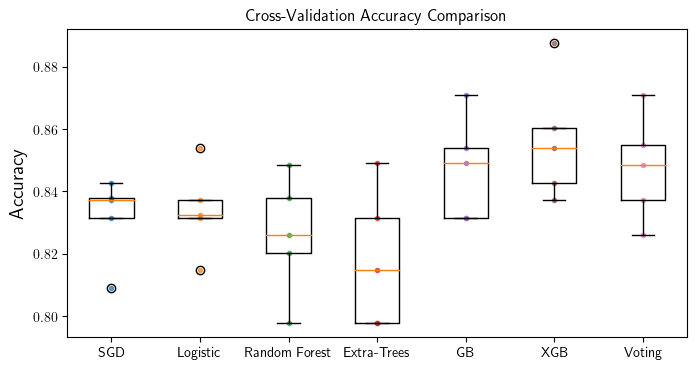

In [68]:
plt.figure(figsize=(8, 4))
plt.plot([1]*len(sgd_scores), sgd_scores, ".", alpha=0.7)
plt.plot([2]*len(log_scores), log_scores, ".", alpha=0.7)
plt.plot([3]*len(rnd_scores), rnd_scores, ".", alpha=0.7)
plt.plot([4]*len(ext_scores), ext_scores, ".", alpha=0.7)
plt.plot([5]*len(gb_scores), gb_scores, ".", alpha=0.7)
plt.plot([6]*len(xgb_scores), xgb_scores, ".", alpha=0.7)
plt.plot([7]*len(vot_scores), vot_scores, ".", alpha=0.7)
# Boxplot
plt.boxplot([sgd_scores, log_scores, rnd_scores, ext_scores, gb_scores, xgb_scores, vot_scores])
plt.ylabel("Accuracy", fontsize=14)
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["SGD", "Logistic",
                              "Random Forest", "Extra-Trees", 
                             "GB", "XGB", "Voting"])
plt.title("Cross-Validation Accuracy Comparison")

plt.show()

Random Forest and Extra-Trees have the lowest mean score among all models. Furthermore, the latter has the largest IQR, indicating that Extra-Trees is the least stable model. The linear models have the narrowest IQR, but they still have smaller mean scores than other models. XGB performs the best, it has the highest mean score, a fair IQR, the highest minimum score and a remarkable outlier at ~0.89.

Based on these results, the **best model is Extreme Gradient Boosting**.
The Voting classifier ties with Gradient Boosting. Despite including XGB, its performance is pulled down by the weaker models in the ensemble (SGD, Logistic, Extra-Trees).

# Supporting evidence

**Extreme Gradient Boosting** was selected and tuned based on `accuracy`, consistent with the Kaggle evaluation metric. The confusion matrix, classification report, and ROC-AUC score below provide supporting evidence that the model has genuine discriminative power and is not simply exploiting the class imbalance between survivors and non-survivors.

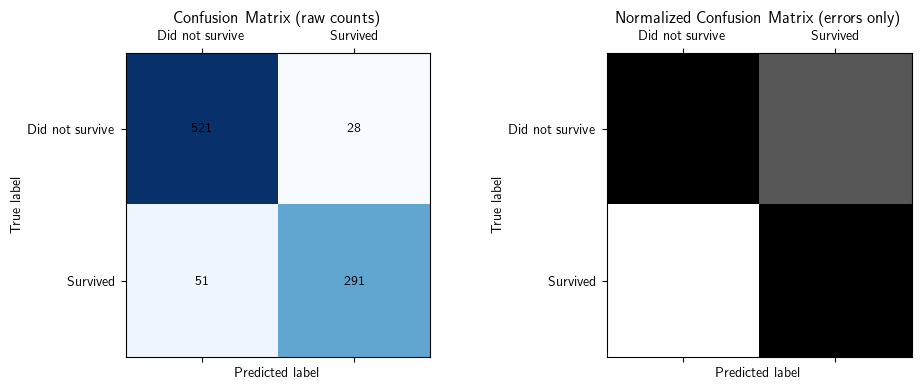

In [69]:
BEST_MODEL = xgb#_clf_model.best_estimator_ 

y_pred_best = BEST_MODEL.predict(X_train)
y_proba_best = BEST_MODEL.predict_proba(X_train)[:, 1]

# --- Confusion Matrix ---
conf_mx = confusion_matrix(y_train, y_pred_best)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)  # Zero out the diagonal to highlight only misclassifications.

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].matshow(conf_mx, cmap=plt.cm.Blues)
axes[0].set_title("Confusion Matrix (raw counts)")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Did not survive', 'Survived'])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Did not survive', 'Survived'])
for (i, j), val in np.ndenumerate(conf_mx):
    axes[0].text(j, i, str(val), ha='center', va='center', color='black')

axes[1].matshow(norm_conf_mx, cmap=plt.cm.gray)
axes[1].set_title("Normalized Confusion Matrix (errors only)")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Did not survive', 'Survived'])
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Did not survive', 'Survived'])


plt.tight_layout()
plt.show()

There are 51 false negatives (wrongly predicted as did not survive), roughly 6% of total data.  

Let's see the classification report for the *best model*:

In [70]:
# --- Classification Report ---
print("------------ Evaluation of BEST_MODEL ------------")
print(classification_report(y_train, y_pred_best, target_names=["Did not survive", "Survived"]))
print(f"ROC-AUC Score: {roc_auc_score(y_train, y_proba_best):.4f}")

------------ Evaluation of BEST_MODEL ------------
                 precision    recall  f1-score   support

Did not survive       0.91      0.95      0.93       549
       Survived       0.91      0.85      0.88       342

       accuracy                           0.91       891
      macro avg       0.91      0.90      0.91       891
   weighted avg       0.91      0.91      0.91       891

ROC-AUC Score: 0.9661


### Interpreting the results

**Confusion matrix:** Displays the four possible prediction outcomes. The raw counts matrix (left) shows absolute numbers. The normalised matrix (right) zeroes out the diagonal to show only errors — a bright bottom-left square means the model misses **many** actual survivors (false negatives); a gray top-right square means it wrongly predicts death for survivors (false positives). 

**Classification report:** Breaks down performance per class. *Precision* measures how often the model is correct when it predicts a given class. *Recall* measures how many of the actual cases of that class the model correctly identified. *F1-score* is the harmonic mean of both — a single number balancing precision and recall. A gap between the two classes signals the model performs unevenly for survivors vs. non-survivors. 

**ROC-AUC score:** Measures how well the model ranks survivors above non-survivors across all possible decision thresholds, independently of the threshold chosen at prediction time. A score of 1.0 is perfect; 0.5 is random guessing. It complements accuracy by revealing whether the model has genuine discriminative power even when classes are imbalanced.

**Important note:** These metrics are computed on the **training data**, since all labelled data is used for training before the Kaggle submission. The cross-validated accuracy of ~0.856 reported above is the more reliable estimate of generalisation performance on unseen data.

## Submission data

In [71]:
y_pred_gb = xgb.predict(X_test)
submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": y_pred_gb
})
submission.to_csv("Data/submission_titanic.csv", index=False)

With this result we got a **0.76315** Public Score.

# Conclusion

In this project, several data quality issues were identified and corrected in both the training and test datasets. Missing values were imputed, irrelevant features were dropped, and new features were engineered (e.g., `FamilySize`, `TicketGroupSize`, `Title` and `Deck`). Six individual models were trained and compared using 5-fold cross-validated accuracy: SGD, Logistic Regression, Random Forest, Extra-Trees, Gradient Boosting, and Extreme Gradient Boosting alongside a Voting Classifier combining all six.

**Extreme Gradient Boosting** achieved the highest mean cross-validated accuracy (0.856) with a reasonable standard deviation (0.018) and was selected as the best model. The supporting confusion matrix and ROC-AUC score confirm the model has genuine discriminative power beyond simply exploiting the class imbalance.

This model was used to generate the Kaggle submission, achieving a **public score of 0.76315**.

Note that no advanced neural network or deep learning approaches were considered — the focus was on the standard scikit-learn workflow. These will be explored in a separate notebook.

### Possible improvements

- The public score of **0.76315** is very close to the trivial *all-women-survive* baseline (~0.766), which suggests the feature set or model tuning still has room to grow.
- **Stacking** (training a meta-model on the out-of-fold predictions of the base models) is a more powerful ensemble technique than simple voting and could improve results. 
- The gap between the cross-validated accuracy (~0.856) and the public leaderboard score (0.763) is substantial, suggesting either overfitting to the training set or that the current features do not generalise well to the test distribution.